# Orbbec Camera 2XL Depth Data Understanding

## 0. Import Library

In [66]:
from pyorbbecsdk import *
from utils import frame_to_bgr_image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import rerun as rr
import rerun.blueprint as rrb
import math

## 1. Utility Function

In [ ]:
def playback_state_callback(state):
    """Callback function to handle playback state transitions."""
    global playback_finished
    if state == OBMediaState.OB_MEDIA_BEGIN:
        print("Bag player begin")
    elif state == OBMediaState.OB_MEDIA_END:
        print("Bag player end")
        playback_finished = True  # Signal that playback has finished
    elif state == OBMediaState.OB_MEDIA_PAUSED:
        print("Bag player paused")

def process_frames(bag_file):
    """
    Process the .bag file and return lists of processed images.
    
    Returns:
        depth_image_list: List of raw depth data (converted to float and scaled).
        color_image_list: List of processed color images.
        overlaid_image_list: List of images with overlay (color blended with depth colormap).
    """
    global playback_finished
    playback_finished = False  # Reset flag

    pipeline = Pipeline(bag_file)
    playback = pipeline.get_playback()
    playback.set_playback_state_callback(playback_state_callback)

    # Start the pipeline
    pipeline.start()

    depth_image_list = []
    color_image_list = []

    while not playback_finished:
        frames = pipeline.wait_for_frames(100)
        if frames is None:
            if playback_finished:
                print("All frames have been processed and converted successfully.")
                break
            continue

        # Retrieve frames once per iteration
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if depth_frame is not None:
            width = depth_frame.get_width()
            height = depth_frame.get_height()
            scale = depth_frame.get_depth_scale()

            # Process raw depth data
            depth_data = np.frombuffer(depth_frame.get_data(), dtype=np.uint16)
            depth_data = depth_data.reshape((height, width))
            depth_data = depth_data.astype(np.float32) * scale
            depth_image_list.append(depth_data)

            # Normalize and invert to obtain desired mapping (farthest = red, closest = blue)
            depth_norm = cv2.normalize(depth_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            inverted_depth = 255 - depth_norm
            depth_image = cv2.applyColorMap(inverted_depth, cv2.COLORMAP_JET)
        else:
            depth_image = None

        if color_frame is not None:
            width = color_frame.get_width()
            height = color_frame.get_height()

            color_data = frame_to_bgr_image(color_frame)
            color_image = cv2.resize(color_data, (width, height))
            # Convert to BGR if necessary; adjust if frame_to_bgr_image already outputs BGR
            color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
            color_image_list.append(color_image)
        else:
            color_image = None

    return depth_image_list, color_image_list

def visualize_depth(rgb_image, depth_image):
    # Visualize the depth prediction using matplotlib
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title("Original Image")
    plt.axis("off")
    print("RGB Image shape:", rgb_image.shape)

    # Depth prediction
    plt.subplot(1, 2, 2)
    plt.imshow(depth_image, cmap="jet")
    plt.title("Depth Image")
    plt.axis("off")
    print("Depth Image shape:", depth_image.shape)

    plt.tight_layout()
    plt.show()

def rerun_visualization(color_image_list: list):
    stream = rr.new_recording("spawn", spawn=True)

    # Setup the blueprint for the layout configuration.
    blueprint = rrb.Blueprint(
        rrb.Grid(
            rrb.Vertical(
                rrb.Spatial2DView(origin='/color_image'),
            ),
        ),
        collapse_panels=True
    )

    # Log images to both recording streams with time sequencing.
    for idx in range(len(color_image_list)):
        stream.set_time_sequence("frame", idx)
        stream.log("color_image", rr.Image(color_image_list[idx]))

    stream.send_blueprint(blueprint)


## 2. Data Understanding

- There five different classes from the data to extracted: **Hand Open**, **Intrinsic Plan**, **Straight Fist**, **Hand Close**, and **Hook Hand**. The illustration is as follows: 

  <img src='../../IMAGES/Classes.jpg' width="500px" />

### 1. Import Data

In [19]:
bags_dir = f'./data/20250402'
bags_file = []

bags_file.extend(glob.glob(os.path.join(bags_dir, '*.bag')))
print("bags_file:", bags_file)

bags_file: ['./data/20250402\\Record_20250402151124.bag', './data/20250402\\Record_20250402151609.bag', './data/20250402\\Record_20250402152331.bag']


### 2. Extract RAW `.bag` Data

- The average calculated from each data recordings is `104` obtain from given expression

  ```python
  # Using a generator expression to calculate total length
  total_data = sum(len(data["depth_images"]) for data in processed_data.values())
  print(f"Sum of data length: {total_data}")

  # Calculate the average data length directly
  average_data = total_data / len(processed_data)
  print(f"Average data length: {average_data:.2f}")
  ```

#### Orbbec Gemini 2XL Depth Camera

**Process RAW `.bag` file**

In [ ]:
processed_data = {}

for idx, bag_file in enumerate(bags_file):
    print(f"Processing bag file: {bag_file}")

    # Process the frames in the bag file
    depth_images, color_images = process_frames(bag_file)

    # Store the lists in the dictionary under the key `recording_{idx}`
    processed_data[f"recording_{idx}"] = {
        "depth_images": depth_images,
        "color_images": color_images
    }

**Visualize Color and Depth Image**

Length of data: 105
RGB Image shape: (800, 1280, 3)
Depth Image shape: (800, 1280)


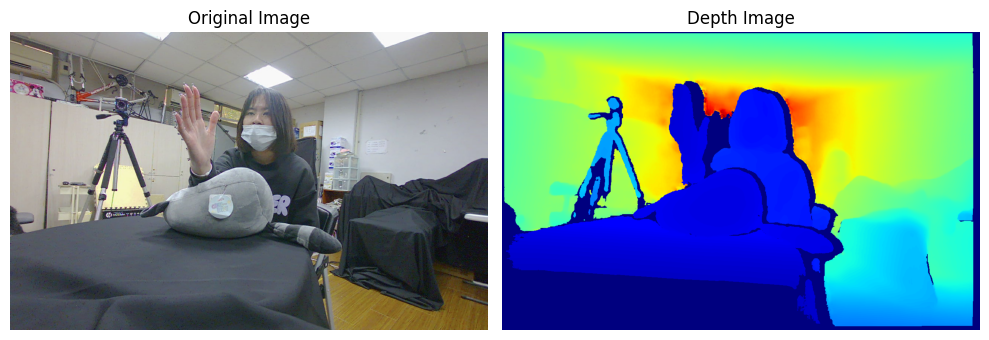

In [36]:
# Retrive the data for recording
recording_0 = processed_data.get("recording_0")

depth_images = recording_0["depth_images"]
color_images = recording_0["color_images"]

print(f"Length of data: {len(depth_images)}")

visualize_depth(color_images[0], depth_images[0])
rerun_visualization(depth_images)

**Segment Data into Five Classes**

In [ ]:
def segment_data(data):
    class_labels = ["Hand Open", "Intrinsic Plan", "Straight Fist", "Hand Close", "Hook Hand"]
    
    required_per_class = 16
    required_total = required_per_class * len(class_labels)
    
    # Use only the first `required_total` frames if there are enough, otherwise use all available frames.
    effective_data = data[:required_total]
    
    segments = {}
    for i, label in enumerate(class_labels):
        start_index = i * required_per_class
        end_index = start_index + required_per_class
        segments[label] = effective_data[start_index:end_index]
        print(f"{label}: From index {start_index} to {end_index} (Total: {len(segments[label])} items)")
    
    return segments

def visualize_frames_matplotlib(frame_list, n_cols=10, figsize=(20, 4)):
    n_frames = len(frame_list)
    n_rows = math.ceil(n_frames / n_cols)
    fig = plt.figure(figsize=figsize)
    
    for i, frame in enumerate(frame_list):
        # Create subplot for each frame; subplot numbering starts at 1
        ax = fig.add_subplot(n_rows, n_cols, i + 1, xticks=[], yticks=[])
        ax.imshow(frame)
        # Place text using normalized axis coordinates (0 to 1) to avoid truncation
        ax.text(0.05, 0.9, f'Frame {i}', transform=ax.transAxes,
                fontsize=14, color='white', clip_on=False,
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        ax.axis('off')
    
    # Adjust the layout to ensure nothing is clipped
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def visualize_frames_rerun(segmented_data):
    """
    Visualizes frames from five segmented image lists using rr and rrb libraries.
    
    The segmented_data dictionary should contain the following keys:
      - "Hand Open"
      - "Intrinsic Plan"
      - "Straight Fist"
      - "Hand Close"
      - "Hook Hand"
      
    Each key maps to a list of image frames. This function iterates over the frames 
    concurrently from each list, logs them to the recording stream with a time sequence,
    and sends the blueprint to visualize them in a grid layout.
    """
    
    # Retrieve image lists from the segmented_data dictionary
    hand_open_list     = segmented_data.get("Hand Open")
    intrinsic_plan_list = segmented_data.get("Intrinsic Plan")
    straight_fist_list = segmented_data.get("Straight Fist")
    hand_close_list    = segmented_data.get("Hand Close")
    hook_hand_list     = segmented_data.get("Hook Hand")
    
    # Create a new recording stream with the "spawn" parameter
    stream = rr.new_recording("spawn", spawn=True)
    
    # Define the blueprint with a grid layout containing five spatial views
    blueprint = rrb.Blueprint(
        rrb.Grid(
            rrb.Spatial2DView(origin='/hand_open_image'),
            rrb.Spatial2DView(origin='/intrinsic_plan_image'),
            rrb.Spatial2DView(origin='/straight_fist_image'),
            rrb.Spatial2DView(origin='/hand_close_image'),
            rrb.Spatial2DView(origin='/hook_hand_image'),
        )
    )
    
    # Loop through all frames concurrently using zip and enumerate for proper looping.
    for idx, (hand_open, intrinsic_plan, straight_fist, hand_close, hook_hand) in enumerate(
        zip(hand_open_list, intrinsic_plan_list, straight_fist_list, hand_close_list, hook_hand_list)
    ):
        stream.set_time_sequence("frame", idx)
        stream.log("hand_open_image", rr.Image(hand_open))
        stream.log("intrinsic_plan_image", rr.Image(intrinsic_plan))
        stream.log("straight_fist_image", rr.Image(straight_fist))
        stream.log("hand_close_image", rr.Image(hand_close))
        stream.log("hook_hand_image", rr.Image(hook_hand))
    
    # Send the blueprint to complete the recording visualization
    stream.send_blueprint(blueprint)

segmented_data = segment_data(color_images)
visualize_frames_rerun(segmented_data)

Hand Open: From index 0 to 16 (Total: 16 items)
Intrinsic Plan: From index 16 to 31 (Total: 15 items)
Straight Fist: From index 31 to 47 (Total: 16 items)
Hand Close: From index 47 to 62 (Total: 15 items)
Hook Hand: From index 62 to 78 (Total: 16 items)


#### MiDaS 3.0

RGB Image shape: (480, 640, 3)
Depth Image shape: (480, 640)


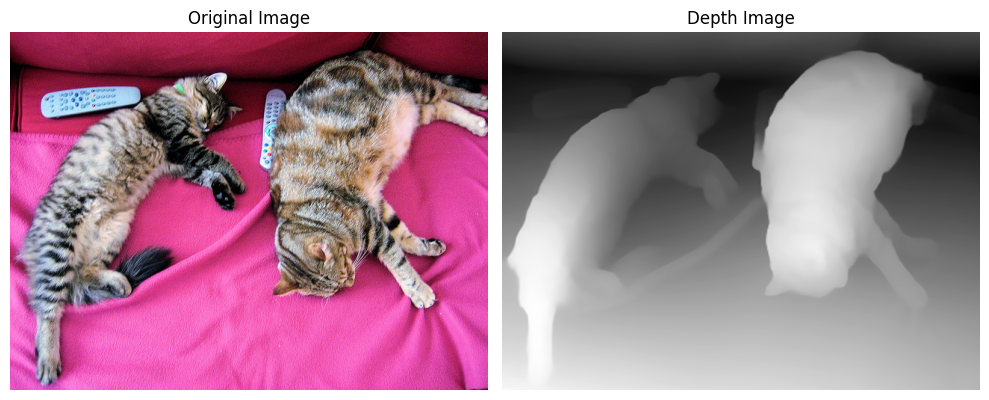

In [32]:
from PIL import Image
import numpy as np
import requests
import torch

from transformers import DPTImageProcessor, DPTForDepthEstimation

image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")

# Convert `image` and `formatted` into numpy array
image = np.array(image)
formatted = np.array(formatted)

visualize_depth(image, formatted)